In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys

sys.path.append('/content/drive/My Drive/DeepLearning/Sunspots')

In [0]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv


--2020-04-19 14:01:21--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45039 (44K) [text/plain]
Saving to: ‘monthly-sunspots.csv’

monthly-sunspots.cs 100%[===================>]  43.98K  --.-KB/s    in 0.01s   

2020-04-19 14:01:21 (2.89 MB/s) - ‘monthly-sunspots.csv’ saved [45039/45039]



In [0]:
import pandas as pd
import os

df = pd.read_csv('monthly-sunspots.csv', index_col='Month')

In [4]:
df.head()
df["Sunspots"].astype('float32')

Month
1749-01    58.000000
1749-02    62.599998
1749-03    70.000000
1749-04    55.700001
1749-05    85.000000
             ...    
1983-08    71.800003
1983-09    50.299999
1983-10    55.799999
1983-11    33.299999
1983-12    33.400002
Name: Sunspots, Length: 2820, dtype: float32

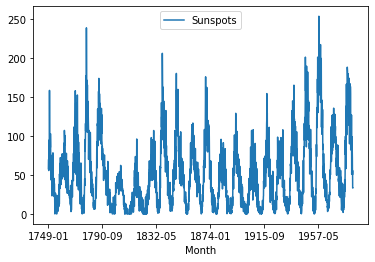

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

df.plot()

In [0]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


training_set = df.values.astype('float32')

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 10
x, y = sliding_windows(training_data, seq_length)
train_size = int(len(training_set) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

print(trainX.shape)
print(trainY.shape)

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
print("test")
print(testX.shape)
print(testY.shape)

torch.Size([2256, 10, 1])
torch.Size([2256, 1])
test
torch.Size([553, 10, 1])
torch.Size([553, 1])


In [0]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [0]:
class RNN(nn.Module):
    
    def __init__(self, dim, n_hidden=64, n_layers=1,
                               drop_prob=0.3, lr=0.001):
        super().__init__()
        self.dim = dim
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        
        # define the LSTM
        self.lstm = nn.LSTM(dim, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(n_hidden, 1)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        #print("input: ", x.shape)
        r_output, hidden = self.lstm(x, hidden)
        #print("before flat: ", r_output.shape)
        last_output = r_output[:,-1]
        #print("last output: ", last_output.shape)
        flat_output = last_output.contiguous().view(-1, self.n_hidden)
        #print("after flat: ", flat_output.shape)
        out = self.fc(flat_output)
        #print("output: ", out.shape)
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        

In [0]:
# train the RNN
def train(network, x_train, y_train, n_epochs, print_every, lr=0.01, seq_len=10):
    network.train()
    
    # initialize the hidden state
    hidden = net.init_hidden(len(x_train))   
    
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)   

        
    if(train_on_gpu):
        network.cuda()

    x_train, y_train = x_train.cuda(), y_train.cuda()
        
    for epoch, step in enumerate(range(n_epochs)):
        # defining the training data 
        # outputs from the rnn
        prediction, hidden = network(x_train, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = tuple([each.data for each in hidden])
        # calculate the loss
        loss = criterion(prediction, y_train)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    return

In [0]:
# define and print the net
n_hidden=32
n_layers=2

net =  RNN(dim=1, n_hidden=n_hidden, n_layers=n_layers, drop_prob=0.3, lr=0.001)
print(net)

RNN(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [0]:
batch_size = 64
seq_length = 10
n_epochs = 60 # start smaller if you are just testing initial behavior

# train the model
net.train()
train(net, trainX, trainY, n_epochs=n_epochs, print_every=10)

Epoch: 0, loss: 0.00348
Epoch: 10, loss: 0.00325
Epoch: 20, loss: 0.00250
Epoch: 30, loss: 0.00250
Epoch: 40, loss: 0.00231
Epoch: 50, loss: 0.00227


In [0]:
# train the RNN
def eval(network, x_test, y_test):
    network.eval()
    # initialize the hidden state
    hidden = None 
    
    criterion = torch.nn.MSELoss()

    if(train_on_gpu):
        network.cuda()

    x_test, y_test = x_test.cuda(), y_test.cuda()
    
    prediction, hidden = network(x_test, hidden)
    # calculate the loss
    loss = criterion(prediction, y_test)

    print("val loss: %1.5f" % (loss.item()))
    return

In [0]:
eval(net, testX, testY)

val loss: 0.00969


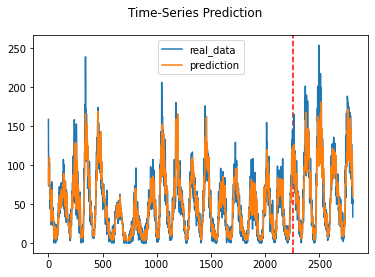

In [0]:
seq_len=10
net.eval()

hidden = None 
dataX = dataX.cuda()

train_predict, _= net(dataX, hidden)

if(train_on_gpu):
    train_predict = train_predict.cpu()
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()
dataY_plot = dataY_plot.reshape(-1,1)

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label="real_data")
plt.plot(data_predict, label="prediction")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.savefig("/content/drive/My Drive/DeepLearning/Sunspots/prediction.png")
plt.show()